In [ ]:
#Import necessary libraries
import tensorflow as tf
from tensorflow.keras import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Connecting Google Drive With Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set training parameters
BATCH_SIZE = 28
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [ ]:
# Load dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/cotton/Working',
    seed = 19,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 843 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['curl_virus', 'healthy']

In [ ]:
len(dataset)

31

In [ ]:
# Display the shape of one batch of images and labels
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(28, 256, 256, 3)
[1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1]


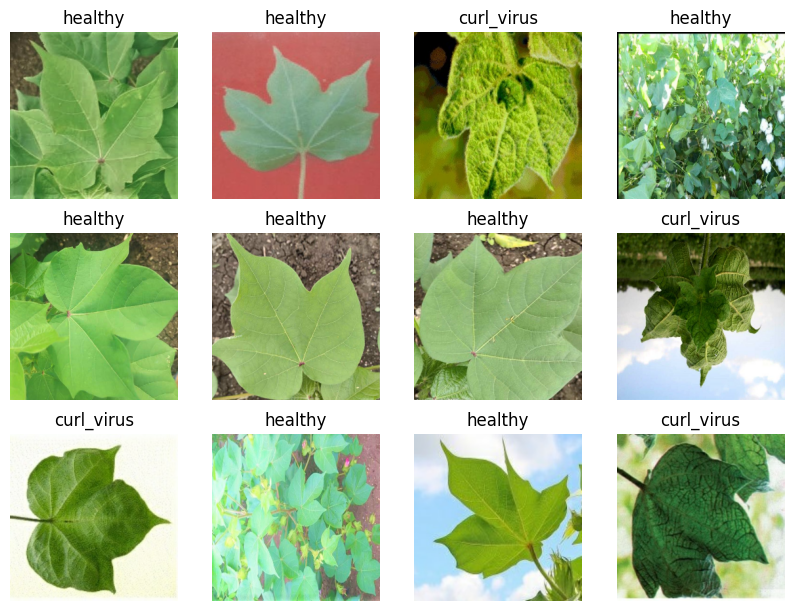

In [ ]:
# Plot sample images from the dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

31

In [ ]:
train_size = 0.8
len(dataset)*train_size


24.8

In [ ]:
train_ds = dataset.take(24)
len(train_ds)

24

In [ ]:
test_ds = dataset.skip(24)
len(test_ds)

7

In [ ]:
val_size=0.1
len(dataset)*val_size

3.1

In [ ]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [ ]:
test_ds = test_ds.skip(3)
len(test_ds)

4

In [ ]:
# Split dataset into training, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)


24

In [ ]:

len(val_ds)

3

In [ ]:
len(test_ds)

4

In [ ]:
# Optimize datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Define preprocessing layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Apply data augmentation to training dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_ds)

24

In [ ]:
# Define the model architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (28, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (28, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (28, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (28, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (28, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (28, 60, 60, 64)         

In [ ]:
# Build and compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
24/24 [==============================] - 98s 4s/step - loss: 0.6976 - accuracy: 0.6295 - val_loss: 0.5760 - val_accuracy: 0.7381
Epoch 2/10
24/24 [==============================] - 84s 3s/step - loss: 0.5819 - accuracy: 0.7098 - val_loss: 0.6670 - val_accuracy: 0.6548
Epoch 3/10
24/24 [==============================] - 83s 3s/step - loss: 0.5318 - accuracy: 0.7396 - val_loss: 0.6239 - val_accuracy: 0.7381
Epoch 4/10
24/24 [==============================] - 85s 4s/step - loss: 0.4483 - accuracy: 0.8140 - val_loss: 0.5983 - val_accuracy: 0.7143
Epoch 5/10
24/24 [==============================] - 83s 3s/step - loss: 0.4672 - accuracy: 0.8110 - val_loss: 0.4652 - val_accuracy: 0.8095
Epoch 6/10
24/24 [==============================] - 87s 4s/step - loss: 0.4130 - accuracy: 0.8110 - val_loss: 0.4540 - val_accuracy: 0.8095
Epoch 7/10
24/24 [==============================] - 83s 3s/step - loss: 0.4114 - accuracy: 0.8289 - val_loss: 0.4348 - val_accuracy: 0.8095
Epoch 8/10
24/24 [==

In [ ]:
# Evaluate the model on the test set
scores = model.evaluate(test_ds)

4/4 [==============================] - 9s 1s/step - loss: 0.3908 - accuracy: 0.8661


In [ ]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

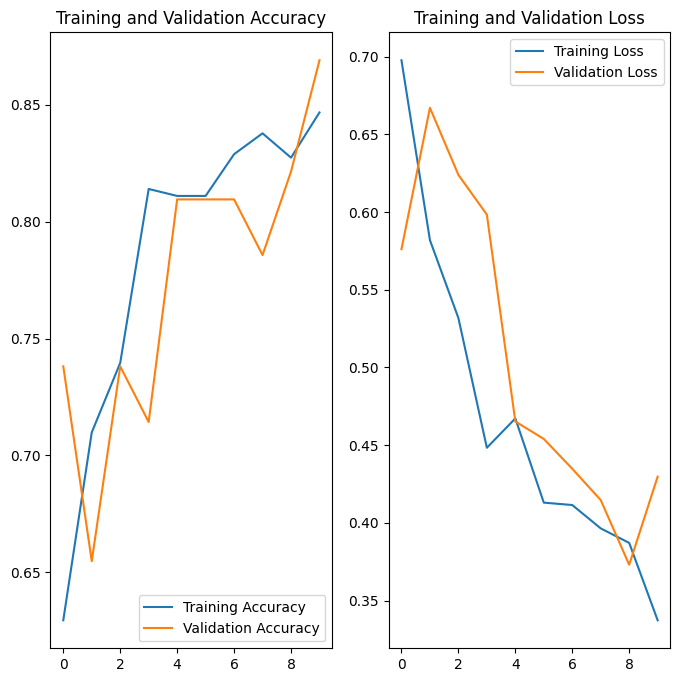

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: healthy
1/1 [==============================] - 1s 927ms/step
predicted label: healthy


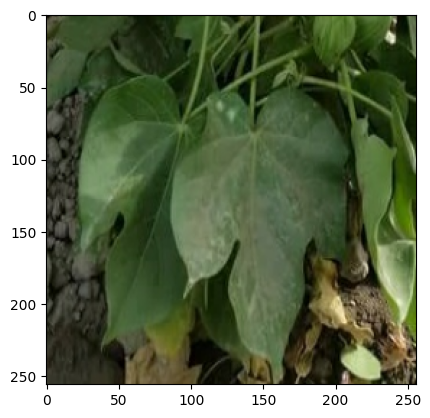

In [ ]:
# Display predictions on the test set
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
# Define prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


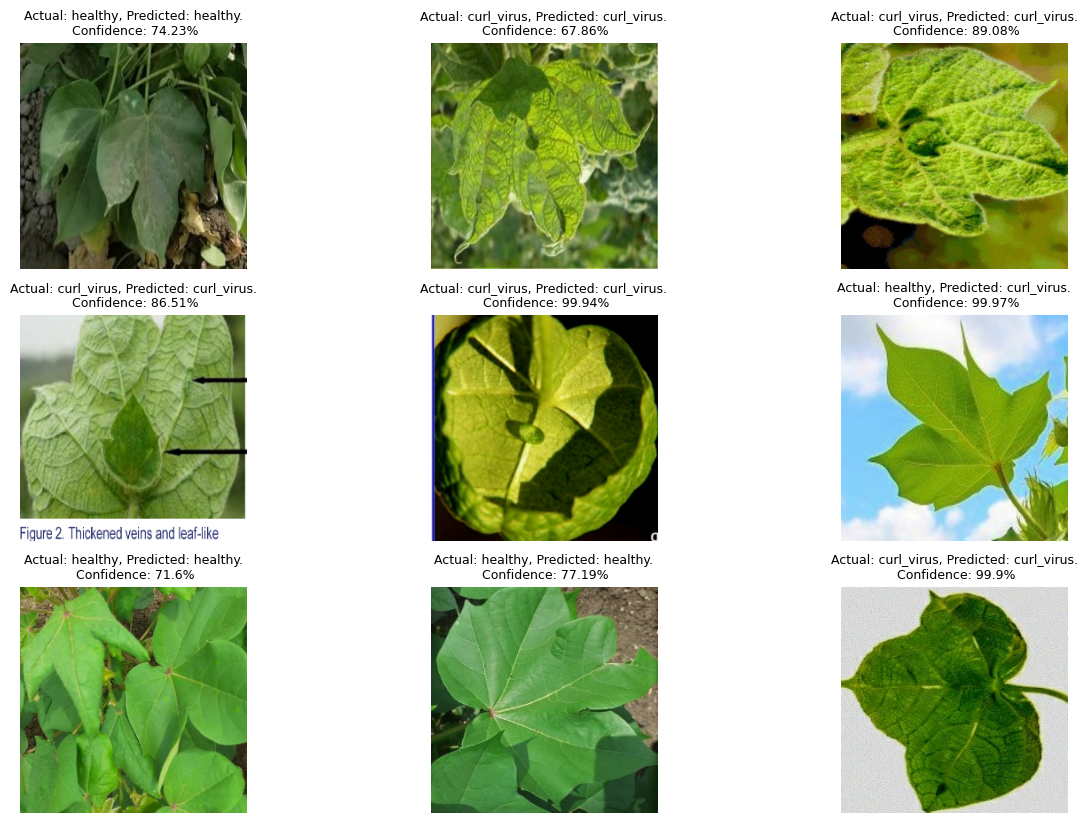

In [ ]:
# Plot predictions on sample images from the test set
plt.figure(figsize=(15, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence: {confidence}%",fontsize = 9)

        plt.axis("off")

In [ ]:
import os
os.listdir('drive/MyDrive/Model')
model.save('drive/MyDrive/Mode')

In [ ]:
model.save("Model")